In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.cuda.empty_cache()
data_dr = './data/cifar10'
classes = os.listdir(data_dr+"/train")
print(classes)

['horse', 'frog', 'cat', 'truck', 'dog', 'automobile', 'ship', 'bird', 'deer', 'airplane']


What are we adding:
-> random data augmentation
-> channel wise data normalisation 
-> using test set for final validation

In [3]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # ((mean),(std_div)) in R,G,B
train_tf = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                       tt.RandomVerticalFlip(),
                       tt.RandomVerticalFlip(),
                       tt.ToTensor(),
                       tt.Normalize(*stats, inplace=True)])
val_tf = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [4]:
train_ds = ImageFolder(data_dr+'/train',train_tf)
val_ds = ImageFolder(data_dr+'/test',val_tf)
batch_size =  400 
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [6]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images,labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        print (labels)
        break

tensor([8, 8, 3, 3, 4, 1, 3, 7, 4, 3, 0, 6, 8, 3, 6, 1, 2, 0, 1, 7, 8, 7, 0, 8,
        0, 5, 9, 9, 6, 6, 4, 3, 0, 1, 4, 2, 8, 0, 6, 9, 1, 7, 3, 5, 8, 2, 6, 1,
        7, 2, 6, 9, 8, 1, 5, 4, 4, 6, 4, 4, 9, 7, 7, 0, 8, 1, 3, 7, 4, 1, 0, 7,
        9, 0, 5, 2, 6, 4, 8, 3, 5, 1, 2, 9, 1, 4, 6, 7, 7, 5, 5, 0, 7, 1, 0, 0,
        6, 1, 6, 1, 6, 5, 3, 4, 6, 8, 5, 9, 1, 0, 5, 3, 8, 9, 8, 4, 6, 2, 1, 4,
        8, 3, 2, 5, 9, 6, 9, 4, 8, 8, 9, 0, 7, 6, 2, 0, 6, 8, 9, 4, 9, 6, 9, 3,
        6, 0, 1, 1, 6, 9, 1, 1, 5, 2, 2, 4, 7, 6, 9, 4, 0, 5, 1, 5, 1, 4, 9, 7,
        9, 7, 0, 6, 9, 5, 2, 3, 2, 3, 6, 8, 7, 8, 5, 9, 1, 3, 4, 3, 1, 0, 0, 1,
        9, 0, 1, 3, 3, 2, 4, 5, 8, 9, 4, 3, 1, 0, 0, 9, 6, 0, 9, 0, 8, 5, 8, 1,
        1, 9, 1, 4, 8, 4, 2, 4, 9, 7, 0, 2, 5, 6, 1, 2, 4, 8, 8, 3, 3, 6, 5, 4,
        0, 2, 3, 1, 9, 0, 2, 3, 9, 6, 6, 6, 9, 9, 1, 9, 9, 4, 9, 1, 4, 3, 3, 8,
        1, 6, 3, 3, 8, 6, 8, 8, 4, 3, 7, 8, 4, 9, 9, 1, 6, 5, 1, 9, 7, 2, 5, 3,
        6, 5, 8, 1, 6, 3, 8, 1, 6, 8, 8,

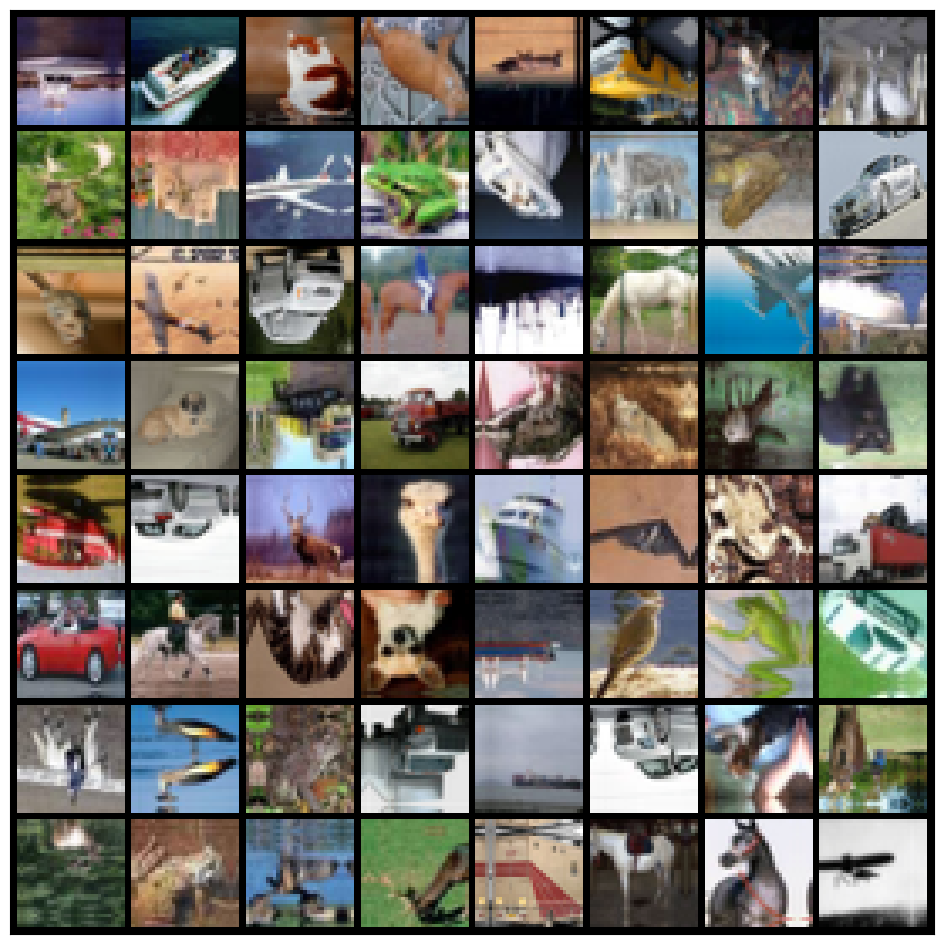

In [7]:
show_batch(train_dl)

In [8]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [9]:
def accuracy(ouputs, lables):
    __, preds = torch.max(ouputs, dim=1)
    return torch.tensor(torch.sum(preds == lables).item() / len(preds))

class ImgClassificactionBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    def val_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    def val_epoc_end(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoc_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoc_acc = torch.stack(batch_acc).mean()
        return {'val_loss': epoc_loss.item(), 'val_acc': epoc_acc.item()}
    def epoc_end(self, epoc, result):
                  print("Epoch"+str(epoc)+", train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(result['train_loss'], result['val_loss'], result['val_acc']))

In [10]:
def conv_bloc(in_channels, out_channels, pool = False):
    layers = [nn.Conv2d(in_channels,out_channels, kernel_size=3,stride=1 ,padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU6(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [11]:
class Resnet9(ImgClassificactionBase):
    def __init__(self, inchannels, num_classes):
        super().__init__()
        self.conv1 = conv_bloc(inchannels, 64) # 64,32,32
        self.conv2 = conv_bloc(64, 128, pool=True) # 128,16,16
        self.res1 = nn.Sequential(conv_bloc(128,128),
                                  conv_bloc(128,128))#128,16,16
        self.conv3 = conv_bloc(128,256,pool=True)#256,8,8
        self.conv4 = conv_bloc(256,512,pool=True)#512,4,4
        self.res2 = nn.Sequential(conv_bloc(512,512),
                                  conv_bloc(512,512))#512,4,4
        self.classifier = nn.Sequential(nn.MaxPool2d(4), #512,1,1
                                        nn.Flatten(), #512
                                        nn.Dropout(0.2), #drops 20% of inputs
                                        nn.Linear(512, num_classes))
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [12]:
model = to_device(Resnet9(3,10),device)
model

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplac

What add here ->One cycle Lr ->Weight Decay ->grdient clipping

In [13]:
@torch.no_grad()
def eval(model, val_dl):
    model.eval()
    outputs = [model.val_step(batch) for batch in val_dl]
    return model.val_epoc_end(outputs)
def get_lr(optm):
    for param_grp in optm.param_groups:
        return param_grp['lr']
def fit_one_cycle(epocs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_fn=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optm = opt_fn(model.parameters(), max_lr, weight_decay=weight_decay)
    schedule = torch.optim.lr_scheduler.OneCycleLR(optm, max_lr, epochs=epocs, steps_per_epoch=len(train_loader))
    for epoc in range(epocs):
        model.train()
        train_losses = []
        lr = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip) #clips if must
            
            optm.step() #optimizer step
            optm.zero_grad()

            lr.append(get_lr(optm)) #getting lr values
            schedule.step()
        results = eval(model, val_loader)
        results['train_loss'] = torch.stack(train_losses).mean().item()
        results['lr'] = lr
        model.epoc_end(epoc, results)
        history.append(results)
    return history

In [14]:
history = [eval(model, val_dl)]
history

[{'val_loss': 2.304664134979248, 'val_acc': 0.0957692414522171}]

In [15]:
epoc = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [16]:
torch.cuda.empty_cache()
history += fit_one_cycle(epoc, max_lr, model, train_dl, val_dl ,grad_clip=grad_clip, weight_decay=weight_decay, opt_fn=opt_func)

Epoch0, train_loss: 1.6243, val_loss: 1.1938, val_acc: 0.5682


KeyboardInterrupt: 

In [ ]:
cur_dir = os.getcwd()
save_path = os.path.join(cur_dir, 'models/Saved-number-aug-CNN-model-weights.pth')
save_path_md = os.path.join(cur_dir, 'models/Saved-number-aug-CNN-model.pt')
torch.save(model.state_dict(),save_path)
torch.save(model, save_path_md)